## 1.1 Approximating $x!$ and $\binom{N}{k}$

## 1.2 Error-correcting codes fort he binary symmetric channel

In [12]:
import requests as rq
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from itertools import product

In [2]:
IMAGE_SHAPE = (200, 400)

In [3]:
image = Image.open(open('./tower.jpg', 'rb')).resize(IMAGE_SHAPE)

# For a binary symmetric model we need to have an image that is either 0 (0) or 1 (255)
bw_image = image.convert('L').point(lambda x: 255 if x > 127 else 0, "1")

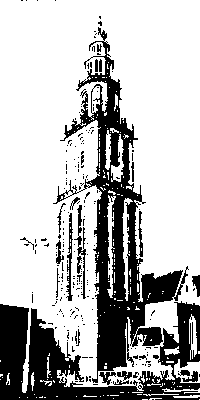

In [4]:
bw_image

In [5]:
s = np.array(bw_image).astype(int).flatten().astype(dtype=np.uint8) # NOTE that you need .T for loading

In [6]:
class BaseClass():
    def encode(self, source):
        pass

    def decode(self):
        pass

    def transport(self, error_prob: float = 0.10):
        if not hasattr(self, "encoded"):
            raise ValueError("First encode a message using self.encode")

        if error_prob >= 0.50:
            raise ValueError("Error prob needs to be <= 50%")

        self.received = (self.encoded + stats.bernoulli(p=error_prob).rvs(self.encoded.size)) % 2

### Repetition codes

The repitition coding is the simplest example where we just take each bit and send it not once but N times. In this case we follow the R3 pattern, meaning that each bit is represented by 3 bits. 

In [26]:
np.vstack(np.array_split(r3.received, r3.source.size))

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 1, 1]])

In [56]:
class Repetition(BaseClass):
    def __init__(self, n_repetition: int = 3):
        if n_repetition % 2 == 0:
            raise ValueError("Majority vote only works for odd parity number of repetitions") 

        self.source = None
        self.decoded = None
        self.n_repetition = n_repetition

    def encode(self, source):
        self.source = source
        self.encoded = np.repeat(source, self.n_repetition)

    def decode(self):
        stacked = np.vstack(np.array_split(self.received, self.source.size))
        self.decoded = (stacked.mean(axis=1) > 0.50).astype(np.uint8)

In [57]:
perc_error = []
transmit_size = []
n_reps = np.arange(1, 10, step=2)

for n_rep in n_reps:
    r3 = Repetition(n_repetition=n_rep)
    r3.encode(s)
    r3.transport()
    r3.decode()

    perc_error.append(np.logical_xor(r3.source, r3.decoded).mean().item() * 100)
    transmit_size.append(r3.encoded.size)

stats_df = pd.DataFrame({
    "per_error": perc_error,
    "size": transmit_size
})
stats_df['original'] = s.size
stats_df['rate'] = stats_df['original'] / stats_df['size']

### The (7, 4) Hamming code

In [58]:
# Voor elke 4 bits heb je 3 controle bits nodig. Algo gaat er wel vanuit dat er maar 1 fout is!!
class ZevenFourHammingCode(BaseClass):
    def __init__(self):
        self.G = np.array([
                    [1, 0, 0, 0, 1, 0, 1], # The encoded blocks are linear combination of codewords
                    [0, 1, 0, 0, 1, 1, 0],
                    [0, 0, 1, 0, 1, 1, 1],
                    [0, 0, 0, 1, 0, 1, 1]
                ])

        self.source_combs = np.array(list(product([0,1], repeat=4)))

        self.codewords = (self.source_combs @ self.G) % 2
        
    def encode(self, source):
        self.source = source
        self.encoded = ((self.source.reshape(-1, 4) @ self.G) % 2).flatten()

    def decode(self):
        # For now we use a simple nearest-neighbor decoding algorithm. This can be improved by a maximum likelihood decoder
        decoded = []

        for row in self.received.reshape(-1, 7):
            decoded.append(hamming.source_combs[np.logical_xor(row, self.codewords).sum(axis=1).argmin()])

        self.decoded = np.stack(decoded).flatten()

In [59]:
hamming = ZevenFourHammingCode()

hamming.encode(s)
hamming.transport()
hamming.decode()

In [60]:
perc_error_hamming = np.logical_xor(hamming.source, hamming.decoded).mean().item() * 100
print(f"Percentage error: {perc_error_hamming:.2f}%")

Percentage error: 6.60%


###  Comparing rate of transmitted signal against percentage error

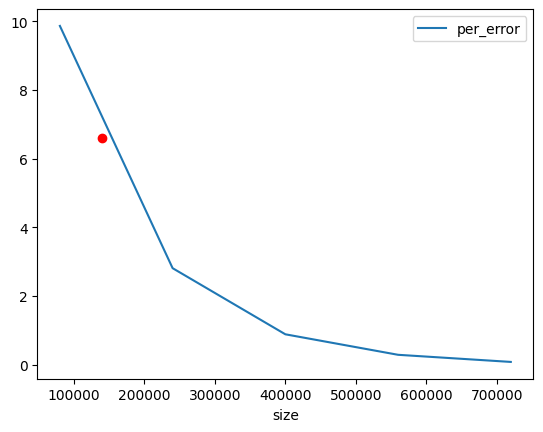

In [61]:
stats_df.plot(x='size', y='per_error')
plt.scatter(hamming.received.size, perc_error_hamming, c='r')

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [83]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(3)),
    ('reg', LinearRegression())
])

clf = pipeline.fit(stats_df['rate'].values.reshape(-1, 1), stats_df['per_error'])

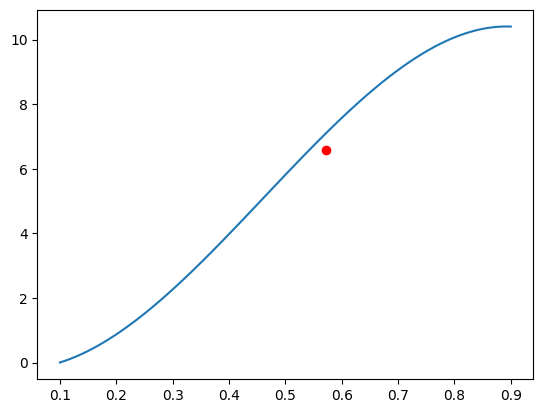

In [86]:
x_range = np.linspace(0.1, 0.9, 100)

plt.plot(x_range, clf.predict(x_range.reshape(-1, 1)))
plt.scatter(s.size / hamming.received.size, perc_error_hamming, c='r')